## 学習と精度を確認する
- 年次ホールドアウト + StratifiedKFold（TF‑IDFはfold内fit, LightGBM）
- 直近 TEST_LAST_N 年を最終テストとして完全にホールドアウト
- それ以前のデータのみで StratifiedKFold を実施（情報リーク防止のため TF‑IDF は fold学習データでfit）
- OOF で 閾値最適化（macro_f1 または balanced_accuracy）

In [289]:
from importlib import reload

from classification import ml_token_classification_rf
from classification import ml_token_classification_xgb
from classification import ml_token_classification_lgb

from classification import ml_numerical_classification_rf
from classification import ml_numerical_classification_xgb
from classification import ml_numerical_classification_lgb

from classification import cm

from sklearn.model_selection import train_test_split

import numpy as np


In [290]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 6
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "project_start_year"   # 年度列（数値化可能であること）
THRESHOLD = 100 # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 5                  # 例: 直近2年をテスト

# TF-IDF
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 3
TFIDF_NGRAM = (1, 2)
# テキストベクトル化の方式を切替
# - 'char': 日本語向けに手軽な文字n-gram（デフォルト）
# - 'word': 形態素解析（fugashi）で単語n-gram
TEXT_TOKENIZER = 'char'  # 'word' or 'word'
CHAR_NGRAM = (2, 4)      # analyzer='char_wb' 時の ngram_range
WORD_NGRAM = (1, 1)      # analyzer='word'（形態素）の ngram_range

# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

# LightGBM デフォルト
LGB_PARAMS = dict(
    objective="binary",
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    is_unbalance=True,  # クラス不均衡設定
)

In [291]:
import pandas as pd
df_ori = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df_ori.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

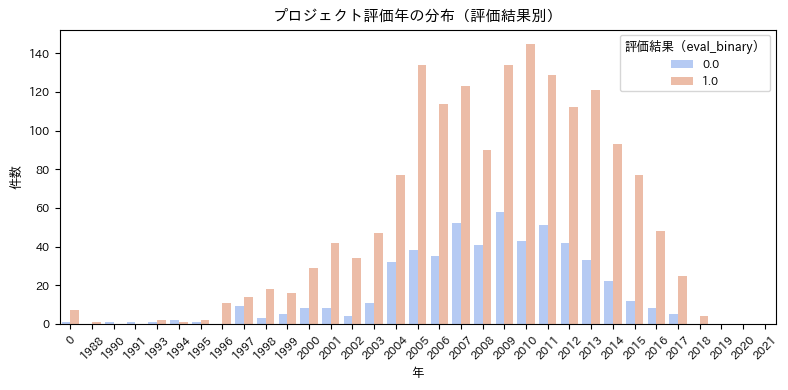

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_ori,
    x=YEAR_COL,
    hue="eval_binary",
    palette="coolwarm"
)
plt.title("プロジェクト評価年の分布（評価結果別）", fontsize=11)  # タイトル小さく
plt.xlabel("年", fontsize=9)                     # 軸ラベル小さく
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)                              # x軸目盛りの文字サイズ
plt.yticks(fontsize=8)                                           # y軸目盛りの文字サイズ
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

In [293]:
# 利用するテキストの特徴量を生成
df_ori['sentence'] = df_ori['background']+df_ori['description']

In [294]:
df_ori = df_ori.rename(columns={
  LABEL_BINARY_COL: "label",
})

In [295]:
## 評価がないレコードを除外
print(df_ori['eval_binary'].isnull().sum())
df_ori = df_ori.dropna(subset=['eval_binary'])

KeyError: 'eval_binary'

In [ ]:
## textがないレコードを除外
print(df_ori['sentence'].isnull().sum())
df = df_ori.dropna(subset=['sentence'])

In [ ]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)]
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)]

# RandomForest
### 実施内容だけでの予測

In [ ]:

reload(ml_token_classification_rf)

ml_token_classification_rf.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_rf.csv','results/classification/result_text_rf.csv')


# XGBoost
### 実施内容だけでの予測

In [ ]:
reload(ml_token_classification_xgb)
ml_token_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_xgb.csv','results/classification/result_text_xgb.csv')


# LighGBM
### 実施内容だけでの予測

In [ ]:
reload(ml_token_classification_lgb)
ml_token_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_lgb.csv','results/classification/result_text_lgb.csv')


## テキスト外特徴量の追加

## 特徴量指定

In [ ]:
df.columns

In [ ]:
ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
]
df = pd.get_dummies(df_ori, columns=ohe_col)


# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
    'sentence', 
]

# one-hot列
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
region_columns = [c for c in df.columns if c.startswith('region_detail_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]
eva_columns = [c for c in df.columns if c.startswith('evaluator_group_')]

features = features + country_columns + type_columns + region_columns + sector_columns + eva_columns


## RandomForest
- 数値系特徴量の追加

In [ ]:
## random forest用にNaN特徴量の行を除外
df_random = df.dropna(subset=features)
rf_feat = features.copy()
rf_feat.remove('sentence')

## train_test分割
train_rf_df = df_random[df_random[YEAR_COL] <= (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_rf_df = df_random[df_random[YEAR_COL] > (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 

In [ ]:
reload(ml_numerical_classification_rf)
ml_numerical_classification_rf.train_and_evaluate_model(train_df=train_rf_df, valid_df=valid_rf_df)

cm.vis('results/classification/confusion_matrix_num_rf.csv','results/classification/result_num_rf.csv')


## XGBoost
- 数値系特徴量の追加

In [ ]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 


In [ ]:
reload(ml_numerical_classification_xgb)
ml_numerical_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df)

cm.vis('results/classification/confusion_matrix_num_xgb.csv','results/classification/result_num_xgb.csv')


## lgbm
- 数値系特徴量の追加

In [ ]:
reload(ml_numerical_classification_lgb)
ml_numerical_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, n_splits=5, threshold_objective="macro_f1")

cm.vis('results/classification/confusion_matrix_num_lgb.csv','results/classification/result_num_lgb.csv')
